In [1]:
import pandas
import wordcloud
import matplotlib.pyplot as plt
import random as rnd
from sklearn.linear_model import LinearRegression
import numpy as np
import math
import nltk

nltk.download('averaged_perceptron_tagger')

data = pandas.read_csv('data.csv', usecols=range(1, 11))

data.head(n=5)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/anej/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,Name,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,Martine of Martine's Table,Amsterdam,"['French', 'Dutch', 'European']",1.0,5.0,$$ - $$$,136.0,"[['Just like home', 'A Warm Welcome to Wintry ...",/Restaurant_Review-g188590-d11752080-Reviews-M...,d11752080
1,De Silveren Spiegel,Amsterdam,"['Dutch', 'European', 'Vegetarian Friendly', '...",2.0,4.5,$$$$,812.0,"[['Great food and staff', 'just perfect'], ['0...",/Restaurant_Review-g188590-d693419-Reviews-De_...,d693419
2,La Rive,Amsterdam,"['Mediterranean', 'French', 'International', '...",3.0,4.5,$$$$,567.0,"[['Satisfaction', 'Delicious old school restau...",/Restaurant_Review-g188590-d696959-Reviews-La_...,d696959
3,Vinkeles,Amsterdam,"['French', 'European', 'International', 'Conte...",4.0,5.0,$$$$,564.0,"[['True five star dinner', 'A superb evening o...",/Restaurant_Review-g188590-d1239229-Reviews-Vi...,d1239229
4,Librije's Zusje Amsterdam,Amsterdam,"['Dutch', 'European', 'International', 'Vegeta...",5.0,4.5,$$$$,316.0,"[['Best meal.... EVER', 'super food experience...",/Restaurant_Review-g188590-d6864170-Reviews-Li...,d6864170


In [4]:
data.loc[0]

Name                                        Martine of Martine's Table
City                                                         Amsterdam
Cuisine Style                          ['French', 'Dutch', 'European']
Ranking                                                              1
Rating                                                               5
Price Range                                                   $$ - $$$
Number of Reviews                                                  136
Reviews              [['Just like home', 'A Warm Welcome to Wintry ...
URL_TA               /Restaurant_Review-g188590-d11752080-Reviews-M...
ID_TA                                                        d11752080
Name: 0, dtype: object

In [5]:
isLjubljana = data['City'] == 'Ljubljana'
data_lj = data[isLjubljana]

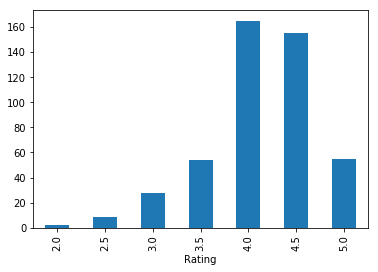

In [6]:
###############################################
# Restaurant rating distribution in Ljubljana #
###############################################

ratings_lj = data_lj['Rating']
vc = ratings_lj.value_counts().sort_index()
ax = vc.plot(kind='bar').set(xlabel="Rating")
plt.show()

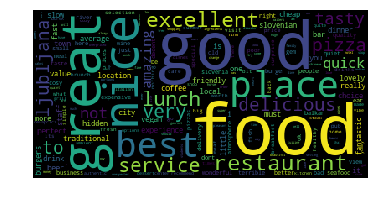

In [7]:
##################################################
# Review word-cloud for restaurants in Ljubljana #
##################################################
import collections as col
import wordcloud
import nltk


occurence_counter = col.Counter()

reviews_lj = data_lj['Reviews']
for revs_restaurant in reviews_lj:
    if not isinstance(revs_restaurant, str):
        continue
    words = revs_restaurant.split(' ');
    for w in words:
        parsed_word = ''.join(c for c in w if c.isalpha()).lower()
        if parsed_word == '':
            continue
        tagged = nltk.pos_tag([parsed_word])
        
        # We want to avoid conjunctions, prepositions, determiners, adpositions and pronouns
        if tagged[0][1] not in ['CC', 'PRON', 'IN', 'DT', 'ADP']:
            occurence_counter[parsed_word] += 1
        
cloud = wordcloud.WordCloud()       
cloud = cloud.generate_from_frequencies(occurence_counter)     


plt.imshow(cloud)
plt.axis("off")
plt.show()


In [8]:
############################################
# Most popular cuisine styles in Ljubljana #
############################################

# INFO: you can parse the arrays inside strings with eval(str)

def countCuisines(data_df):
    occurence_counter = col.Counter()

    for styles in data_df['Cuisine Style']:
        if not isinstance(styles, str):
            continue
        styles_arr = eval(styles)
        for s in styles_arr:
            occurence_counter[s] += 1

    return pandas.Series(occurence_counter, name='count')



df_count = countCuisines(data_lj).to_frame().reset_index()
df_count.columns = ['Cuisine_style', 'count']
df_count = df_count.sort_values(by=['count'], ascending=False).head(n=15).reset_index()[['Cuisine_style','count']]
df_count.index = df_count.index + 1
df_count

,Cuisine_style,count
1,European,247
2,Slovenian,174
3,Vegetarian Friendly,129
4,Central European,117
5,Mediterranean,87
6,Vegan Options,65
7,Italian,64
8,Pizza,62
9,Gluten Free Options,61
10,Bar,51


In [9]:
################################################################################################
# Construct a dataframe, where the columns represent the cuisine style distribution in a city. #
################################################################################################

all_styles = set()

for styles in data['Cuisine Style']:
    if not isinstance(styles, str):
        continue
    styles_arr = eval(styles)
    for s in styles_arr:
        all_styles.add(s)

df_allstyles = pandas.Series(list(all_styles)).to_frame()
df_allstyles.columns = ['Cuisine_style']


In [10]:
# Calculate cuisine style popularity vectors for each city, normalize them and add them to dataframe

for grp in data.groupby('City'):
    df_city = grp[1]
    df_counts = countCuisines(df_city)

    # Divide count by number of all cuisine style in the dataset
    #df_counts = df_counts.apply(lambda x: x / df_counts.sum())
    

    df_counts = df_counts.to_frame().reset_index()
    df_counts.columns = ['Cuisine_style', grp[0]]   # Set city name as column name
    
    df_allstyles = df_allstyles.merge(df_counts, on='Cuisine_style', how='left')

df_allstyles = df_allstyles.fillna(0.0)

df_allstyles.index = df_allstyles['Cuisine_style']
df_allstyles = df_allstyles.drop(['Cuisine_style'], axis=1)

df_allstyles.head(n=10)

,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,...,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich
Cuisine_style,,,,,,,,,,,,,,,,,,,,,
Salvadoran,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cajun & Creole,3.0,0.0,2.0,3.0,0.0,2.0,1.0,2.0,1.0,0.0,...,2.0,0.0,2.0,30.0,0.0,1.0,1.0,0.0,0.0,0.0
Wine Bar,23.0,65.0,125.0,73.0,28.0,50.0,50.0,42.0,38.0,30.0,...,30.0,62.0,15.0,364.0,80.0,215.0,17.0,135.0,38.0,33.0
Brew Pub,4.0,9.0,45.0,12.0,12.0,41.0,10.0,7.0,7.0,5.0,...,8.0,5.0,6.0,98.0,18.0,147.0,4.0,14.0,23.0,0.0
Ukrainian,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,3.0,4.0,1.0,1.0,4.0,10.0,0.0
Belgian,19.0,0.0,9.0,1.0,3.0,719.0,7.0,2.0,1.0,2.0,...,0.0,2.0,0.0,25.0,5.0,2.0,3.0,1.0,4.0,1.0
Ecuadorean,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Polish,0.0,0.0,2.0,12.0,1.0,2.0,1.0,0.0,1.0,2.0,...,1.0,0.0,1.0,7.0,1.0,1.0,4.0,6.0,539.0,0.0
French,227.0,23.0,78.0,157.0,15.0,525.0,43.0,95.0,51.0,44.0,...,64.0,14.0,37.0,5647.0,98.0,18.0,65.0,38.0,40.0,50.0


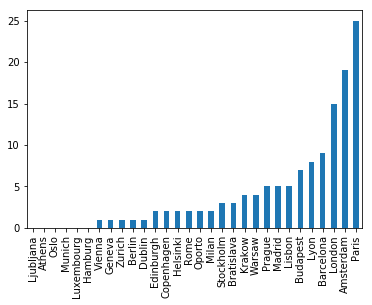

In [11]:
#########################################################################
# Find cities, where a certain cuisine style is not present yet or rare #
#########################################################################


# Belgian food:
belgian = df_allstyles.loc['Belgian'].sort_values(ascending=True).head(n=30)
belgian.plot(kind='bar')
plt.show()

In [12]:
#################################################################
# Constructing a dataset of restaurants for regression learning #
#################################################################

restaurants = data.drop(columns=["Ranking", "Reviews", "URL_TA", "ID_TA"])

restaurants['NumOfSameType'] = 0.0
restaurants['Cuisine Style'] = restaurants['Cuisine Style'].fillna('Fck')
restaurants = restaurants[restaurants['Cuisine Style'] != "Fck"]
restaurants = restaurants[restaurants['Number of Reviews'] > 5.0]
restaurants['Rating'] = restaurants['Rating'].fillna(0.0)
restaurants['Price Range'] = restaurants['Price Range'].fillna("$")
restaurants['Number of Reviews'] = restaurants['Number of Reviews'].fillna(0.0)
restaurants['ID'] = range(0, len(restaurants))

restaurants = restaurants.set_index('ID')

# Replacement of dollar signs in price range
price_range = []
for entry in restaurants['Price Range']:
    if entry == "":
        price_range.append(0)
    elif entry == "$":
        price_range.append(1)
    elif entry == "$$" :
        price_range.append(2)
    elif entry == "$$$" or entry == "$$ - $$$":
        price_range.append(3)
    elif entry == "$$$$":
        price_range.append(4)
    else:
        print(entry)
        price_range.append(-1)
      
restaurants['Price Range'] = price_range

In [13]:
###########################################################
# How many restaurants of same style are in the same town #
###########################################################
#
#    SPODNJA KODA JE ZE POGNANA IN ZAPISANA 
#    V FILE "NumOfSameType.txt"
#    read je v naslednjem odseku
#
###########################################################
'''
sums = list()
lim = 1

for row in restaurants.iterrows():
    row = pandas.DataFrame.from_dict(row[1]).T.set_index('Name')
    #if (lim > 4):
    #    break
    #else:
    #    lim += 1
    sumSameStyle = 0
    city = row['City']
    
    if not isinstance(row['Cuisine Style'][0], str):
        continue
        
    styles = row['Cuisine Style'][0]
    styles_arr = eval(styles)
    for s in styles_arr:
        sumSameStyle += df_allstyles.loc[s, city][0]
    sums.append(sumSameStyle)
    
    
#sums
'''
print('')

In [14]:
###########################################################################
# DON'T RUN -- ONLY run it when changing the initial restaurant dataframe #
###########################################################################
# 
# vse vsote zapisi v file da ni treba laufat vsakic 10 minut
#
#with open("NumOfSameType.txt", 'w') as myfile:
    #wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    #wr.writerow(sums)

In [15]:
#restaurants['NumOfSameType'] = sums
with open('NumOfSameType.txt', 'r') as f:
    vals = f.read().split(',')
    restaurants['NumOfSameType'] = [float(i) for i in vals]

In [16]:
####################################################################
# Dodajanje atributa SuccRating - ocena kk uspesna je restavracija #
####################################################################

restaurants['SuccRating'] = ((restaurants['Rating'] ** 2)  * (restaurants['Number of Reviews']) / restaurants['NumOfSameType'])

restaurants.head(5)

,Name,City,Cuisine Style,Rating,Price Range,Number of Reviews,NumOfSameType,SuccRating
ID,,,,,,,,
0,Martine of Martine's Table,Amsterdam,"['French', 'Dutch', 'European']",5.0,3,136.0,2605.0,1.305182
1,De Silveren Spiegel,Amsterdam,"['Dutch', 'European', 'Vegetarian Friendly', '...",4.5,4,812.0,4243.0,3.875324
2,La Rive,Amsterdam,"['Mediterranean', 'French', 'International', '...",4.5,4,567.0,4368.0,2.628606
3,Vinkeles,Amsterdam,"['French', 'European', 'International', 'Conte...",5.0,4,564.0,4570.0,3.085339
4,Librije's Zusje Amsterdam,Amsterdam,"['Dutch', 'European', 'International', 'Vegeta...",4.5,4,316.0,5155.0,1.241319


In [17]:
##################################################
# Pripravi test in learn set in testiraj dolzino #
##################################################
#
# 7 : 3 = učna : testna
# 


learnBoolArr = []
for ID in restaurants.index:
    r = rnd.randint(0, 10)
    if r < 8:
        learnBoolArr.append(True)
    else:
        learnBoolArr.append(False)

# test set
learn = restaurants[learnBoolArr]
learn

# learn set
testBoolarr = [not e for e in learnBoolArr]
test = restaurants[testBoolarr]
test



print(len(learn))
print(len(test))

if (len(learn) + len(test) == len(restaurants.index)):
    print("Correct lenghts!")


55776
21081
Correct lenghts!


In [18]:
learn.head(5)

,Name,City,Cuisine Style,Rating,Price Range,Number of Reviews,NumOfSameType,SuccRating
ID,,,,,,,,
2,La Rive,Amsterdam,"['Mediterranean', 'French', 'International', '...",4.5,4,567.0,4368.0,2.628606
3,Vinkeles,Amsterdam,"['French', 'European', 'International', 'Conte...",5.0,4,564.0,4570.0,3.085339
4,Librije's Zusje Amsterdam,Amsterdam,"['Dutch', 'European', 'International', 'Vegeta...",4.5,4,316.0,5155.0,1.241319
5,Ciel Bleu Restaurant,Amsterdam,"['Contemporary', 'International', 'Vegetarian ...",4.5,4,745.0,2834.0,5.323306
7,Blue Pepper Restaurant And Candlelight Cruises,Amsterdam,"['Asian', 'Indonesian', 'Vegetarian Friendly',...",4.5,4,675.0,2868.0,4.765952


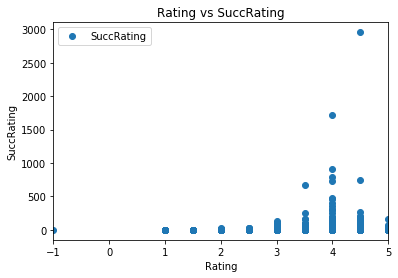

In [19]:
#########################################################
# Samo ocena kako sta v korelaciji Rating in Succrating #
#########################################################

learn.plot(x="Rating", y='SuccRating',  style="o")
plt.title('Rating vs SuccRating')  
plt.xlabel('Rating')  
plt.ylabel('SuccRating')  
plt.show()

In [20]:
test = test.drop(columns=['City', 'Cuisine Style', 'Name'])

learn = learn.drop(columns=['City', 'Cuisine Style', 'Name'])


In [21]:
learn.head(2)

,Rating,Price Range,Number of Reviews,NumOfSameType,SuccRating
ID,,,,,
2,4.5,4,567.0,4368.0,2.628606
3,5.0,4,564.0,4570.0,3.085339


In [22]:
####################################################################
# Učenje linearnega regresorja in razdelitev na atribute in labele #
####################################################################
#
# neodvisne spremenljivke, katerih valuesi se nucajo za napovedovanje
#
attributes = learn.drop(columns=['SuccRating'])
#
# spremenlijvke katerih valuesi se bodo napovedovali
#
labels = learn['SuccRating']

model = LinearRegression()  
model.fit(attributes, labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [23]:
y_pred = model.predict(test.drop(columns=['SuccRating']))

In [24]:
print(test[0:4]['SuccRating'].values)
print(y_pred[0:4])

def MSE(Y, YH):
     return np.square(Y - YH).mean()

#test

[ 1.30518234  3.87532406  6.03518025  6.43620868]
[ 3.15104811  5.58620669  7.86314088  6.61212574]


In [25]:
#############################################################################################
# Napovedane in dejanske podatke spravimo v svoj dataframe in kasneje dodamo še MSE stolpec #
#############################################################################################

predicitons = pandas.DataFrame(test['SuccRating'])
pred_vs_actual = pandas.DataFrame()
pred_vs_actual['Predicted'] = y_pred
pred_vs_actual['Actual'] = test['SuccRating'].values

pred_vs_actual.head(10)


,Predicted,Actual
0,3.151048,1.305182
1,5.586207,3.875324
2,7.863141,6.035180
3,6.612126,6.436209
4,4.098021,8.042807
5,5.472908,3.638378
6,5.554723,14.418591
7,7.474720,5.482240
8,10.141324,8.195432
9,8.176372,12.748001


In [26]:
#################################
# Računanje MSE za vse elemente #
#################################

mse_arr = []
for row in range(0, len(pred_vs_actual)):
    this_row = pred_vs_actual[row:row+1].values[0]
    mse_arr.append(MSE(this_row[0], this_row[1]))
                   


In [27]:
########################################
# IZRAČUN KOLIKO OCEN CCA JE UPORABNIH #
########################################


pred_vs_actual['MSE'] = mse_arr

# all cool
len1 = len(pred_vs_actual[pred_vs_actual['MSE'] < 2])
len2 = len(pred_vs_actual.index)

# cool asf
print(len1, len2)

# eh? a je butast
print(len1 / len2)

# wtf?
print((len1+0) / (len2+0))

# still wtf but now it works
print(float(len1+0) / (len2+0))

#fuck i hate python
print ("-----\nProcent uporabnih ocen: " + str(float(len1+0) / (len2+0) * 100))

(11184, 21081)
0
0
0.530525117404
-----
Procent uporabnih ocen: 53.0525117404
